In [1]:
import pandas as pd
import os
import math
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
import numpy as np

In [2]:
raw_data = pd.read_csv('raw_data.csv')
print(raw_data.shape)
raw_data.columns.values

(5287, 13)


array(['star', 'lat', 'long', 'order_day', 'checkin_day', 'size',
       'orientation', 'bed', 'attribute_number', 'max_guest_number',
       'have_breakfast', 'cancel_ticket', 'price'], dtype=object)

In [3]:
# chia dữ liệu thành X và y
raw_X = raw_data.drop('price', axis=1).values
print(raw_X.shape)
raw_y = raw_data.price.values
print(raw_y.shape)

(5287, 12)
(5287,)


In [4]:
# chia dữ liệu
train_raw_X, test_raw_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=0.2, random_state=10)
#train_raw_X, val_raw_X, train_raw_y, val_raw_y = train_test_split(train_raw_X, train_raw_y, test_size=0.25, random_state=10)

print(train_raw_X.shape)
print(train_y.shape)
print(test_raw_X.shape)
print(test_y.shape)

(4229, 12)
(4229,)
(1058, 12)
(1058,)


In [5]:
#Hàm tính khoảng cách giữa 2 địa điểm dựa vào tọa độ
def cal_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import datetime

In [7]:
class CalDistance(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        F = X.copy()
    
        lat = F[:,1]
        long = F[:,2]
        F = np.delete(F, np.s_[1,2], 1)
        
        #Tọa độ sân bay TP Đà Lạt
        lat_Airport = 11.7490819
        long_Airport = 108.3661379

        #Toạ độ bến xe TP Đà Lạt
        lat_Station = 11.9282352
        long_Station = 108.4438984

        #Toạ độ trung tâm TP Đà Lạt
        lat_Center = 11.9404598
        long_Center = 108.4349727
        
        distance = []
        for i in range(0,len(lat)):
            tmp = []
            tmp.append(-cal_distance((lat_Airport, long_Airport), (lat[i], long[i])))
            tmp.append(-cal_distance((lat_Station, long_Station), (lat[i], long[i])))
            tmp.append(-cal_distance((lat_Center, long_Center), (lat[i], long[i]))) 
            distance.append(tmp)
        
        F = np.column_stack((F, distance))        
        return F

In [8]:
class CalTime(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        F = X.copy()
        order = F[:,1]
        check_in = F[:,2]
        F = np.delete(F, np.s_[1,2], 1)
        
        # tính khoảng cách với ngày lễ
        holidays = [ '24-12', '1-1' ]
        holiday_check = []
        week_day = []
        time_distance = []
        for i in range(0,len(check_in)):
            ci = datetime.datetime.strptime(check_in[i], '%d-%m-%Y')
            val = 0
            for k in [-1,0,1]:
                tmp = ci + datetime.timedelta(days=k)
                for j in range(0, len(holidays)):
                    p = holidays[j].split('-')
                    if tmp.day == int(p[0]) and tmp.month == int(p[1]):
                        val = 1
                        break
                if val == 1:
                    break
            holiday_check.append(val)
            week_day.append(ci.weekday())
            
            o = datetime.datetime.strptime(order[i], '%d-%m-%Y')
            time_distance.append(-abs((ci-o).days))    
        
        F = np.column_stack((F, time_distance))
        F = np.column_stack((F, holiday_check))                
        F = np.column_stack((F, week_day))
        return F

In [9]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [10]:
class CustomOneHotEncoder(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols        
    def fit(self, X, y=None):
        self.dict = {}
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            self.dict[col] = X[:,col].max() + 1
        return self
    def transform(self, X, y=None):
        F = X.copy()
        
        encoders = []
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            encoder = np.zeros((len(F), self.dict[col]))
            
            for j in range(0,len(F)):
                if F[j,col] <= self.dict[col] - 1:
                    encoder[j][F[j,col]] = 1
                        
            encoders.append(encoder)
        
        for i in range(0,len(encoders)):
            F = np.delete(F, np.s_[self.cols[i]], 1)
        for i in range(0,len(encoders)):    
            F = np.column_stack((F, encoders[i]))
        
        return F

In [11]:
class CustomEncoder(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols        
    def fit(self, X, y=None):
        self.dict = {}
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            self.dict[col] = LabelEncoder()
            self.dict[col].fit(X[:,col])
        return self
    def transform(self, X, y=None):
        F = X.copy()
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            F[:,col] = self.dict[col].transform(F[:,col])
        return F

In [12]:
def split_number_text(raw):
    number = '0'
    text = ''
    for i in range(0,len(raw)):
        if raw[i] >= '0' and raw[i] <= '9':
            number += raw[i]
        else:
            text += raw[i]
    return int(number), text
        
    
class CalBed(TransformerMixin):
    def __init__(self):
        self.col = 2
    def fit(self, X, y=None):
        self.max = 1
        self.dict = {} 
        for i in range(0, len(X)):
            bed = X[i][self.col].split('/')[0].replace(' ','')
            detail = bed.split('+')
            for j in range(0,len(detail)):
                number,text=split_number_text(detail[j])
                if text in self.dict:
                    continue
                else:
                    self.dict[text] = self.max
                    self.max += 1
            
            
        return self
    def transform(self, X, y=None):
        F = X.copy()
        
        encoder = np.zeros((len(F), self.max))
        for i in range(0, len(F)):
            bed = X[i][self.col].split('/')[0].replace(' ','')
            detail = bed.split('+')
            for j in range(0,len(detail)):
                number,text=split_number_text(detail[j])
                if text in self.dict:
                    encoder[i][self.dict[text]] = number
                else:
                    continue
        
        F = np.delete(F, np.s_[self.col], 1)
        F = np.column_stack((F, encoder))
                               
        return F

In [13]:
class CustomStandardScaler(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols        
    def fit(self, X, y=None):
        self.dict = {}
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            mean = X[:,col].mean()
            std = X[:,col].std()
            self.dict[col] = (mean,std)
        return self
    def transform(self, X, y=None):
        F = X.copy()
        for i in range(0,len(self.cols)):
            col = self.cols[i]
            (mean,std) = self.dict[col]
            F[:,col] = (F[:,col] - mean) / std
        return F

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [15]:
preprocess_X_pipeline = Pipeline([("cal_distance_extracter", CalDistance()),
                               ("cal_time_extracter", CalTime()),
                               ("cal_orientation_extracter", CustomEncoder([2])),
                               ("custom_onehotencoder_extracter", CustomOneHotEncoder([2,-1])),
                               ("cal_bed_extracter", CalBed()), 
                               ("custom_standard_scalerextracter", CustomStandardScaler([0,1,2,3,6,7,8,9]))])

In [16]:
# chia dữ liệu train thành tập train và tập validation
tmp_train_X, tmp_val_X, tmp_train_y, tmp_val_y = train_test_split(train_raw_X, train_y, test_size=0.25, random_state=10)

# size = 0.25 để tập validation bằng số dòng với tập test
#   vì 0.25 * 80% = 0.2 * 100%

pre_tmp_train_X = preprocess_X_pipeline.fit_transform(tmp_train_X)
pre_tmp_val_X = preprocess_X_pipeline.transform(tmp_val_X)

In [17]:
print(len(pre_tmp_train_X[0]))
print(len(pre_tmp_val_X[0]))

33
33


In [18]:
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()
regressor.fit(pre_tmp_train_X, tmp_train_y)

# Xem giá trị của các tham số của mô hình
print(regressor.coef_)
print(regressor.intercept_)

[ 3.69398118e+05  2.97653472e+04  4.27100467e+04  8.53983769e+04
 -7.77293450e+04 -8.89182343e+04  2.97636420e+04 -7.28829846e+04
  9.35487469e+04  3.61387678e+04 -1.89174898e-10 -2.08717516e+05
  7.37135461e+04 -7.66706979e+04  9.20211893e+04  5.13522700e+04
 -9.47124069e+04  2.45232730e+05 -8.22191144e+04 -9.61754109e+04
 -5.97741862e+04 -2.91615206e+04 -2.72632447e+04  7.66480733e+04
  1.01525636e+05  3.42006535e+04  2.91038305e-11 -1.76593461e+05
 -4.11886728e+04 -3.36222659e+05 -1.65719896e+05  0.00000000e+00
 -9.31902308e+04]
1056780.6176914845


In [19]:
# Xây dựng các hàm độ đo r^2 trên tập huấn luyện
def compute_mse(y, predictions):
    return ((y - predictions) ** 2).mean()
def compute_rr(y, predictions, baseline_prediction):
    return 1 - compute_mse(y, predictions) / compute_mse(y, baseline_prediction)
baseline_prediction = train_y.mean() 

In [20]:
# dự đoán trên tập dữ liệu train bằng mô hình Linear Regression
prediction_X = regressor.predict(pre_tmp_train_X)
print('Prediction in Training Dataset')
print('R2 :', compute_rr(tmp_train_y, prediction_X, baseline_prediction))
print('RMSE:', math.sqrt(compute_mse(tmp_train_y, prediction_X)))

Prediction in Training Dataset
R2 : 0.6181800078371091
RMSE: 345065.5890182804


In [21]:
# dự đoán trên tập dữ liệu validation bằng mô hình Linear Regression
prediction_X = regressor.predict(pre_tmp_val_X)
print('Prediction in Validation Dataset')
print('R2 :', compute_rr(tmp_val_y, prediction_X, baseline_prediction))
print('RMSE :', math.sqrt(compute_mse(tmp_val_y, prediction_X)))

Prediction in Validation Dataset
R2 : 0.6205692174996245
RMSE : 375213.091102566


In [22]:
# Sơ đồ đánh giá dữ liệu dự đoán tập validation bằng mô hình Linear Regression

import matplotlib.pyplot as plt
plt.scatter(tmp_val_y, prediction_X)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
from sklearn.neural_network import MLPRegressor

In [24]:
neural_net_model = MLPRegressor(hidden_layer_sizes=(21), activation="relu",
                                solver="lbfgs", max_iter=1000, random_state=0)
neural_net_model.fit(pre_tmp_train_X, tmp_train_y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=21, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [25]:
# dự đoán trên tập dữ liệu train bằng mô hình Neural Net
prediction_X = neural_net_model.predict(pre_tmp_train_X)
print('Prediction in Training Dataset')
print('R2 :', compute_rr(tmp_train_y, prediction_X, baseline_prediction))
print('RMSE:', math.sqrt(compute_mse(tmp_train_y, prediction_X)))

Prediction in Training Dataset
R2 : 0.9621549352880887
RMSE: 108636.79540274148


In [26]:
# dự đoán trên tập dữ liệu validation bằng mô hình Neural Net
prediction_X = neural_net_model.predict(pre_tmp_val_X)
print('Prediction in Validation Dataset')
print('R2 :', compute_rr(tmp_val_y, prediction_X, baseline_prediction))
print('RMSE :', math.sqrt(compute_mse(tmp_val_y, prediction_X)))

Prediction in Validation Dataset
R2 : 0.9557223022694312
RMSE : 128175.26300624864


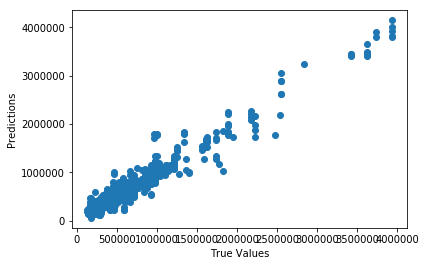

In [27]:
# Sơ đồ đánh giá dữ liệu dự đoán tập validation bằng mô hình Neural Net

import matplotlib.pyplot as plt
plt.scatter(tmp_val_y, prediction_X)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [28]:
# Validation với KFold (K = 5)
from sklearn.model_selection import KFold

In [29]:
kf = KFold(n_splits=5)

In [30]:
i = 0
max_r2 = 0
max_train_index = []
max_test_index = []
for train_index, test_index in kf.split(train_raw_X):
    i += 1
    kf_train_X = train_raw_X[train_index]
    kf_train_y = train_y[train_index]
    kf_val_X = train_raw_X[test_index]
    kf_val_y = train_y[test_index]
    
    kf_train_X = preprocess_X_pipeline.fit_transform(kf_train_X)
    kf_val_X = preprocess_X_pipeline.transform(kf_val_X)
    
    # Dự đoán bằng mô hình Neural Net như phía trên
    neural_net_model.fit(kf_train_X, kf_train_y)
    prediction_X = neural_net_model.predict(kf_val_X)
    score = compute_rr(kf_val_y, prediction_X, baseline_prediction)
    print(i, score)
    if score > max_r2:
        max_train_index = train_index
        max_test_index = test_index

1 0.9210023803342182
2 0.9533267931610689
3 0.9389684144422598
4 0.9503479694488216
5 0.9416743312415888


In [31]:
# Dự đoán trên tập dữ liệu test (private)

In [32]:
# Bằng mô hình ban đầu

Prediction in Test Dataset
R2 : 0.9472853942012732
RMSE : 127448.79200837402


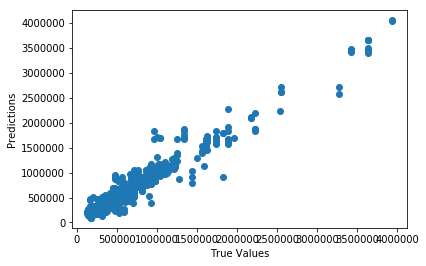

In [33]:
# fit dữ liệu tập train
pre_tmp_train_X = preprocess_X_pipeline.fit_transform(tmp_train_X)
test_X = preprocess_X_pipeline.transform(test_raw_X)

neural_net_model.fit(pre_tmp_train_X, tmp_train_y)

# dự đoán trên tập dữ liệu test bằng mô hình Neural Net
prediction_X = neural_net_model.predict(test_X)
print('Prediction in Test Dataset')
print('R2 :', compute_rr(test_y, prediction_X, baseline_prediction))
print('RMSE :', math.sqrt(compute_mse(test_y, prediction_X)))

# Sơ đồ đánh giá dữ liệu dự đoán tập test bằng mô hình Neural Net
plt.scatter(test_y, prediction_X)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [34]:
# Bằng mô hình thu được bằng sử dụng K-Fold

Prediction in Test Dataset
R2 : 0.952794978067991
RMSE : 120604.73083360025


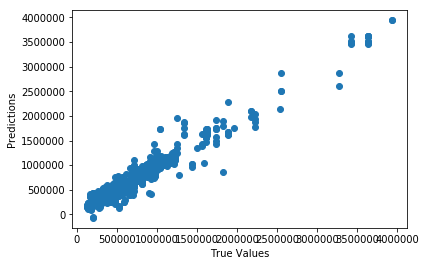

In [35]:
kf_train_X = train_raw_X[max_train_index]
kf_train_y = train_y[max_train_index]
    
kf_train_X = preprocess_X_pipeline.fit_transform(kf_train_X)
test_X = preprocess_X_pipeline.transform(test_raw_X)

neural_net_model.fit(kf_train_X, kf_train_y)

# dự đoán trên tập dữ liệu validation bằng mô hình Neural Net
prediction_X = neural_net_model.predict(test_X)
print('Prediction in Test Dataset')
print('R2 :', compute_rr(test_y, prediction_X, baseline_prediction))
print('RMSE :', math.sqrt(compute_mse(test_y, prediction_X)))

# Sơ đồ đánh giá dữ liệu dự đoán tập test bằng mô hình Neural Net
plt.scatter(test_y, prediction_X)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()